<a href="https://colab.research.google.com/github/ArlexMR/ECE-614-DeepLearning/blob/main/ECE_614_LAB2_JM_AM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 614 - DEEP LEARNING
# SPRING 2023
### LABORATORY 2
#### JOHN MOORE and ARLEX MARIN

# Install and import required libraries

In [ ]:
!pip install keras-tuner -q

In [ ]:
#@title Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import keras
from keras.layers.core import Dense, Dropout
from keras.models import Sequential
from keras.datasets import cifar10
from keras import optimizers
from keras import regularizers
import keras_tuner
import plotly.graph_objects as go

# Functions

In [ ]:
def plot_sample_images(X, y, images_per_class, gridspec_kw):
  fig, axs = plt.subplots(10, images_per_class, figsize = (12,18), gridspec_kw = gridspec_kw )

  axs = axs.flatten()
  ax_idx = 0
  
  for class_ in range(10):

    all_indices = np.flatnonzero(y == class_)
    rand_sampl  = np.random.choice(all_indices, size = images_per_class, replace = False)
    ax = axs[ax_idx]
    ax.annotate(f"{class_}: {class_names[class_]}" , xy = (-0.05,0.5), xycoords = "axes fraction", ha = "right", va = "center", fontsize = 14)

    for sample_idx in rand_sampl:
        ax = axs[ax_idx] 
        ax.imshow(X[sample_idx], cmap = "gray")
        ax.set_xticks([])
        ax.set_yticks([])

        ax_idx += 1

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def to_categorical(arr, num_classes):
  return np.eye(num_classes)[arr.flatten()]  

def get_model(n_hidden, neurons_per_layer, hidden_activation, weights_regularizer, optimizer, dropout_rate = None):

  model = Sequential()
  model.add(keras.Input(shape=(1024,)))

  if dropout_rate is not None:
        model.add(Dropout(dropout_rate))

  for i in range(n_hidden):
      model.add(Dense(neurons_per_layer, 
                      activation          = hidden_activation, 
                      kernel_regularizer  = weights_regularizer, 
                      name                = f"hidden_{i+1}")
                )
      if dropout_rate is not None:
        model.add(Dropout(dropout_rate))
  
  model.add(Dense(10, activation = "softmax" ,name = "Output"))

  model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ["accuracy"])

  return model


def build_model_tuner(hp):
    # Hyperparameters for Keras Tuner to choose from:
    n_hidden          = hp.Int("n_hidden", min_value=4, max_value=8, step=2)
    units             = hp.Int("units", min_value=64, max_value=128, step=64)
    activation        = hp.Choice("activation", ["relu", "tanh"])

    regularizer_type  = hp.Choice("regularizaton_type", ["l1", "l2"])
    reg_fact          = hp.Float("regularizer_factor", min_value = 1e-2, max_value = 1e-1, step = 10, sampling = "log")

    if regularizer_type == "l1":
      regularizer = regularizers.l1(reg_fact)
    else:
      regularizer = regularizers.l2(reg_fact)

    optimizer_type    = hp.Choice("optimizer_type", ["sgd", "adam"])
    lr = hp.Float("lr", min_value = 1e-4, max_value = 1e-3, step = 10, sampling = "log")
    dec     = 0.01
    mome  = hp.Float("momentum", min_value = 0.5, max_value = 0.8, step = 0.3)
    
    if optimizer_type == "sgd":
      #decay     = 0.01
      #momentum  = hp.Float("momentum", min_value = 0.5, max_value = 0.8, step = 0.3)
      optimizer = optimizers.SGD(learning_rate =  lr, decay = dec, momentum = mome)
    else:
      optimizer = optimizers.Adam(learning_rate =  lr)

    if hp.Boolean("dropout"):
      dropout_rate = hp.Float("dropout_rate", min_value = 0.2, max_value = 0.5, step = 0.15)
    else:
      dropout_rate = None
    # call existing model-building code with the hyperparameter values.
    model = get_model(n_hidden            = n_hidden, 
                      neurons_per_layer   = units, 
                      hidden_activation   = activation, 
                      weights_regularizer = regularizer, 
                      optimizer           = optimizer,
                      dropout_rate        = dropout_rate, 
                      )
    return model


# Prepare Data

In [ ]:
(x_train_c, y_train), (x_test_c, y_test) = cifar10.load_data()

x_train_g   = rgb2gray(x_train_c)
y_train_cat = to_categorical(y_train, num_classes = 10)
x_train_g   = x_train_g.astype('float32')/255

x_test_g    = rgb2gray(x_test_c)
y_test_cat  = to_categorical(y_test, num_classes = 10)
x_test_g    = x_test_g.astype('float32')/255

class_names = {0: "Airplane",
               1: "Automobile",
               2: "Bird",
               3: "Cat",
               4: "Deer",
               5: "Dog",
               6: "Frog",
               7: "Horse",
               8: "Ship",
               9: "Truck"
               }

# Sample images 

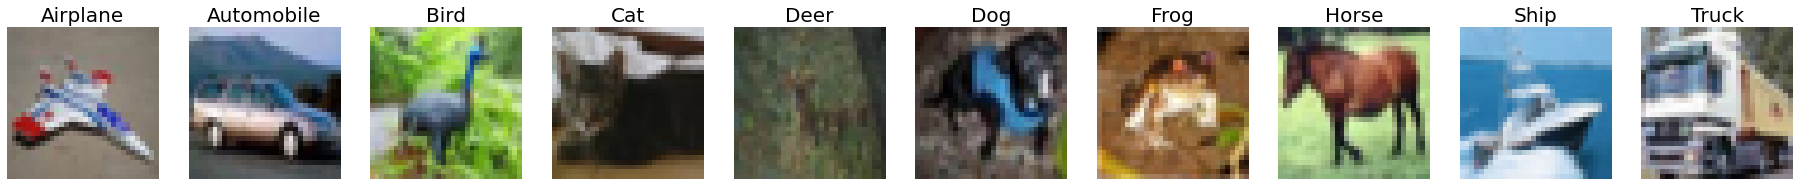

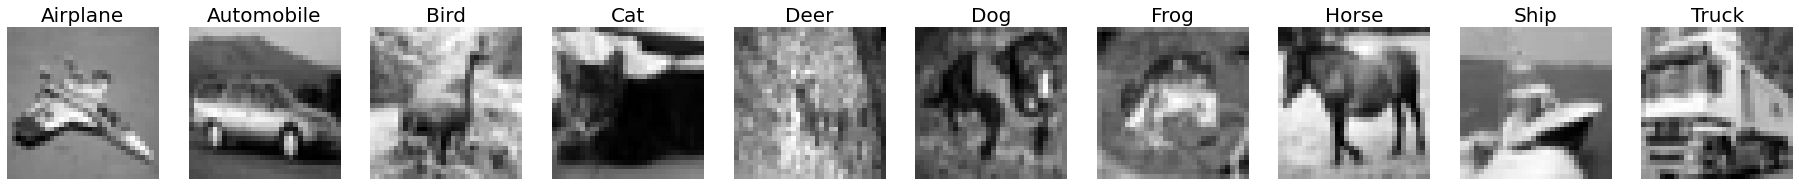

In [ ]:

#RGB Images
f, axarr = plt.subplots(nrows=1, ncols=10, figsize=[32,32])
axarr[0].imshow(x_train_c[30]) # airplane 
axarr[1].imshow(x_train_c[4]) # automobile
axarr[2].imshow(x_train_c[6]) # bird
axarr[3].imshow(x_train_c[9]) # cat
axarr[4].imshow(x_train_c[10]) # deer
axarr[5].imshow(x_train_c[27]) # dog 
axarr[6].imshow(x_train_c[0]) # frog
axarr[7].imshow(x_train_c[7]) # horse
axarr[8].imshow(x_train_c[8]) # ship
axarr[9].imshow(x_train_c[1]) # truck
for i in range(10):
    axarr[i].axis('off')
cols = ['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck']
for t in range(10):
    axarr[t].set_title(cols[t], fontsize=20)

#Grayscale Images
f, axarr = plt.subplots(nrows=1, ncols=10, figsize=[32,32])
axarr[0].imshow(x_train_g[30],cmap='gray') # airplane 
axarr[1].imshow(x_train_g[4],cmap='gray') # automobile
axarr[2].imshow(x_train_g[6],cmap='gray') # bird
axarr[3].imshow(x_train_g[9],cmap='gray') # cat
axarr[4].imshow(x_train_g[10],cmap='gray') # deer
axarr[5].imshow(x_train_g[27],cmap='gray') # dog 
axarr[6].imshow(x_train_g[0],cmap='gray') # frog
axarr[7].imshow(x_train_g[7],cmap='gray') # horse
axarr[8].imshow(x_train_g[8],cmap='gray') # ship
axarr[9].imshow(x_train_g[1],cmap='gray') # truck
#Turn off axes
for j in range(10):
  axarr[j].axis('off')
for t in range(10):
    axarr[t].set_title(cols[t], fontsize=20)

# Hyperparameter Optimization 
Since the random search take several hours to run, the results can be directly loaded running the cell `load results` below

In [ ]:
#@title Instantiate a Random search Tuner 

tuner = keras_tuner.RandomSearch(hypermodel           = build_model_tuner,
                                 objective            = "val_accuracy",
                                 max_trials           = 100,
                                 executions_per_trial = 1, 
                                 overwrite            = True,
                                 directory            = "/content/Tuner"
                                 )
tuner.search_space_summary()

In [ ]:
#@title Execute Random search
x_train_in = x_train_g.reshape(50000,-1)
x_test_in  = x_test_g.reshape(10000,-1)

tuner.search(x_train_in, 
             y_train_cat, 
             epochs = 100, 
             batch_size = 64, 
             validation_data = (x_test_in, y_test_cat)
             )

In [ ]:
#@title Load Tuner results summary
tuner_summary = pd.read_csv("https://raw.githubusercontent.com/ArlexMR/ECE-614-DeepLearning/main/Lab2/Tuner_Summary.csv")

tuner_summary["activation"]         = tuner_summary["activation"].map({"relu":1,"tanh":2})
tuner_summary["regularizaton_type"] = tuner_summary["regularizaton_type"].map({"L2":2,"L1":1})
tuner_summary["optimizer_type"]     = tuner_summary["optimizer_type"].map({"SGD":1,"Adam":2})

In [ ]:
#@title Parallel plot
fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = tuner_summary['val_acc'],
                   colorscale = 'Bluered',
                   showscale = False,
                   cmin = 0,
                   cmax = 0.35),
        dimensions = list([
            dict(range = [4,8],
                 label = "Layers", values = tuner_summary['n_hidden']), 
            dict(range = [64,128],
                 label = 'Neurons', values = tuner_summary['units']),
            dict(tickvals = [1,2],
                 ticktext = ['ReLU','tanh'],
                 label = 'Activ.\nFunc.', values = tuner_summary['activation']),
            dict(tickvals = [1,2],
                 ticktext = ["l1","l2"],
                 label = 'Regularization', values = tuner_summary['regularizaton_type']),
            dict(tickvals = [1,2],
                 ticktext = ["0.001","0.01"],
                 label = 'Reg. factor', values = tuner_summary['regularizer_factor'].map({0.01:1,0.1:2})),
            dict(tickvals = [1,2],
                 ticktext = ["SGD","Adam"],
                 label = 'Optimizer', values = tuner_summary['optimizer_type']),
            dict(tickvals = [1,2,3],
                 ticktext = ["0.0001","0.001","0.01"],
                 label = 'Learning\nrate', values = tuner_summary['lr'].map({0.0001:1, 0.001:2, 0.01:3})),
            dict(range = [0,1],
                 label = 'Dropout', values = tuner_summary['dropout_rate']),
            dict(range = [0,1],
                 label = 'Moment.', values = tuner_summary['momentum']),
            dict(range = [0,1],
                 label = 'Train Acc.', values = tuner_summary['train_acc']),
            dict(range = [0,1],
                 label = 'Val. Acc.', values = tuner_summary['val_acc']), 
            ]),
        labelfont={"size": 14},
        tickfont = {"size": 14}          
    ),
)

fig.show()

# Optimal model

In [ ]:
#@title Build model
n_hidden = 8
neurons_per_layer = 256
hidden_activation = 'relu'
regularizer = regularizers.l2(0.0001)
lr = 0.0001
optimizer = optimizers.Adam(learning_rate =  lr) # for Adam optimizer
dropout_rate = 0.3

model = get_model(n_hidden, neurons_per_layer, hidden_activation, regularizer, optimizer, dropout_rate = dropout_rate)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 hidden_1 (Dense)            (None, 256)               262400    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 hidden_2 (Dense)            (None, 256)               65792     
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 hidden_3 (Dense)            (None, 256)               65792     
                                                                 
 dropout_12 (Dropout)        (None, 256)              

## Train model

In [ ]:
#@title Fit Optimal Model to CIFAR10 Dataset
x_train_in = x_train_g.reshape(50000,-1)
x_test_in  = x_test_g.reshape(10000,-1)
history    = model.fit(x_train_in,
                       y_train_cat,
                       epochs          = 200,
                       batch_size      = 128,
                       verbose         = 1,
                       validation_data = (x_test_in, y_test_cat)
                      )

Epoch 1/200
391/391 [==============================] - 20s 49ms/step - loss: 2.5202 - accuracy: 0.1017 - val_loss: 2.5000 - val_accuracy: 0.1501
Epoch 2/200
391/391 [==============================] - 15s 39ms/step - loss: 2.4589 - accuracy: 0.1362 - val_loss: 2.4109 - val_accuracy: 0.1559
Epoch 3/200
391/391 [==============================] - 12s 30ms/step - loss: 2.3954 - accuracy: 0.1545 - val_loss: 2.3639 - val_accuracy: 0.1776
Epoch 4/200
391/391 [==============================] - 11s 29ms/step - loss: 2.3644 - accuracy: 0.1669 - val_loss: 2.3668 - val_accuracy: 0.1684
Epoch 5/200
391/391 [==============================] - 12s 30ms/step - loss: 2.3356 - accuracy: 0.1788 - val_loss: 2.3518 - val_accuracy: 0.1817
Epoch 6/200
391/391 [==============================] - 12s 29ms/step - loss: 2.3049 - accuracy: 0.1990 - val_loss: 2.2918 - val_accuracy: 0.2164
Epoch 7/200
391/391 [==============================] - 11s 29ms/step - loss: 2.2735 - accuracy: 0.2139 - val_loss: 2.2710 - val_ac

## Loss curves

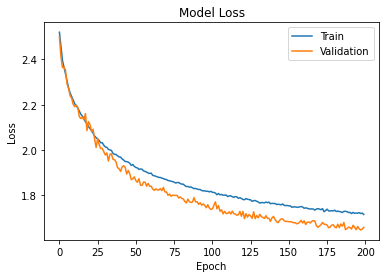

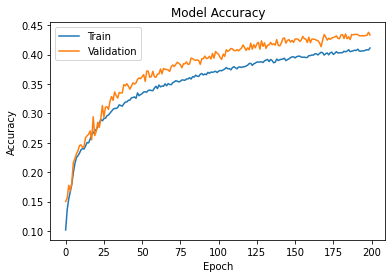

In [18]:
#@title Show Loss and Accuracy Plots
#Loss Plot
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss'); plt.xlabel('Epoch')
plt.legend(('Train','Validation'))

#Accuracy Plot
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy'); plt.xlabel('Epoch')
plt.legend(('Train','Validation'))

plt.show()